In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Dataset & dataloader

In [3]:
from src.tool.registry import DATASET_REGISTRY

dataset = DATASET_REGISTRY['Pedar_Dataset_footprint2pressure'](
    device=device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap',
    pedar_dynamic = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
)

In [4]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
len(train_dataset), len(test_dataset)

(40, 10)

In [5]:
from src.tool.registry import DATALOADER_REGISTRY

train_dataloader = DATALOADER_REGISTRY['DataLoader'](train_dataset, batch_size=32, shuffle=True)
test_dataloader = DATALOADER_REGISTRY['DataLoader'](test_dataset, batch_size=32, shuffle=True)

In [6]:
from tqdm.auto import tqdm

for batch, (x, y) in tqdm(enumerate(train_dataloader)):
    pass

0it [00:00, ?it/s]

In [8]:
x[0].shape, x[0].device

(torch.Size([8, 198, 10, 10]), device(type='mps', index=0))

## MLP prototype

In [9]:
import torch
from torch import nn

from src.tool.registry import MODEL_REGISTRY

# @MODEL_REGISTRY.register()
class MLP(nn.Module):
    def __init__(self, device, img_width: int = 10):
        super().__init__()
        self.device = device
        self.img_width = img_width
        
        self.position_embedding = nn.Embedding(99, int(self.img_width * self.img_width / 2))
        self.young_embedding = nn.Linear(1, int(self.img_width * self.img_width / 2))

        self.model = nn.Sequential(
            nn.Linear(self.img_width * self.img_width * 2, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 1),
        )

        # remember to send model to device!
        self.to(self.device)

    def forward(self, x):
        img_stack, young = x
        
        # reshape img_stack
        infer_shape = img_stack.shape[:-2] + (self.img_width * self.img_width,)  # e.g. (..., 198, 10, 10) -> (..., 198, 100)
        img_stack = img_stack.reshape(infer_shape)

        # positional embedding
        pos_arr = torch.concat([
            torch.arange(99, device=self.device),
            torch.arange(99, device=self.device),
            ], dim=-1,
        )
        pos_emb = self.position_embedding(pos_arr)
        pos_emb = pos_emb.expand(img_stack.shape[:-1] + (-1,))  # e.g. (198, 50) -> (..., 198, 50)

        # youngs' modulus embedding
        young_emb = self.young_embedding(young.unsqueeze(-1))
        young_emb = young_emb.unsqueeze(-2).expand(img_stack.shape[:-1] + (-1,))  # e.g. (50,) -> (..., 198, 50)

        x = torch.cat([img_stack, pos_emb, young_emb], dim=-1)
        
        return self.model(x).squeeze(-1)

In [10]:
mlp = MLP(device=device)
out = mlp(x)
out.shape

torch.Size([8, 198])

In [25]:
batch = 0

x[1][batch]

tensor(3.0102, device='mps:0')

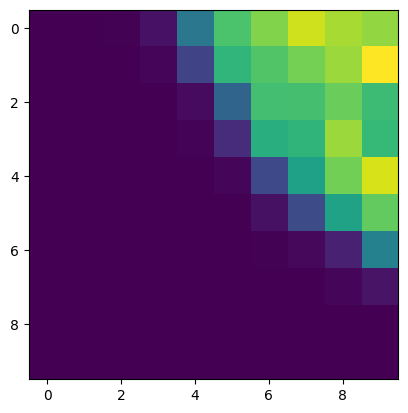

In [26]:
from matplotlib import pyplot as plt

sensor = 10
plt.imshow(x[0][batch][sensor].cpu().detach().numpy())
plt.show()

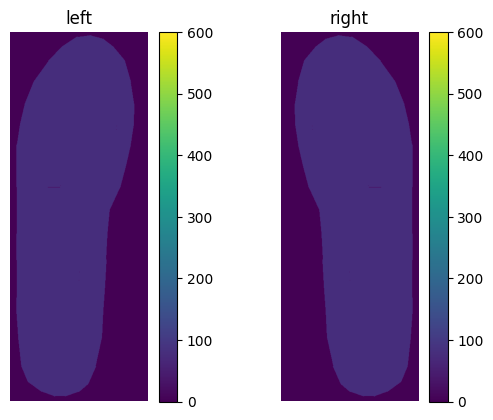

In [34]:
from src.tool import visual

visual.draw_heatmap(
    out[batch].cpu().detach().numpy() * dataset.sense_range,
    '../../data/processed/left_foot_mask.png',
    )